# SECTION 1 : IMPORTS AND CONFIGURATION


In [1]:
# ============================================================================

# Core numerical computing library - handles arrays, matrix operations, math
import numpy as np

# Data manipulation and loading CSV files
import pandas as pd

# Visualization library for plotting loss curves and results
import matplotlib.pyplot as plt

# Make plots appear in notebook
%matplotlib inline


# Random seed for reproducibility - same random numbers every run
RANDOM_STATE = 42

# Number of training samples to use (subset of full 630k for faster learning)
N_SAMPLES = 600000

# Learning rate (eta) - controls step size in gradient descent
# Too large = overshooting, too small = slow convergence
LEARNING_RATE = 0.01

# Number of passes through the entire dataset during training
N_EPOCHS = 300

# Path to training data
DATA_PATH = "data/train.csv"

# Features to use (numeric only for now, we'll skip categoricals)
# We avoid 'id' because it has no predictive power
NUMERIC_FEATURES = [
    'age',
    'study_hours', 
    'class_attendance',
    'sleep_hours'
]

# Target column name
TARGET = 'exam_score'

# Set numpy random seed for reproducible weight initialization
np.random.seed(RANDOM_STATE)

print("Imports and configuration loaded")
print(f"  - Using {N_SAMPLES} samples")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - Epochs: {N_EPOCHS}")
print(f"  - Features: {NUMERIC_FEATURES}")
print(f"  - Target: {TARGET}")
print(f"  - Data path: {DATA_PATH}")
# ============================================================================

Imports and configuration loaded
  - Using 600000 samples
  - Learning rate: 0.01
  - Epochs: 300
  - Features: ['age', 'study_hours', 'class_attendance', 'sleep_hours']
  - Target: exam_score
  - Data path: data/train.csv


# SECTION 2 : DATA LOADING



In [2]:
def load_data(path: str, features: list, target: str, n_samples: int):
    """
    Load training data from CSV and prepare features and target.
    
    Args:
        path: Path to the CSV file
        features: List of feature column names to use
        target: Name of the target column
        n_samples: Number of samples to load (None = all data)
    
    Returns:
        X: Feature matrix as numpy array, shape (n_samples, n_features)
        y: Target vector as numpy array, shape (n_samples,)
    """
    
    df = pd.read_csv(path, nrows=n_samples) # Load data from CSV into dataframe using pandas

    x_df = df[features]  # Select only the specified feature columns

    y_df = df[target]    # Select the target column as a pandas Series

    x = x_df.to_numpy()  # Convert feature dataframe to numpy array

    y = y_df.to_numpy()  # Convert target series to numpy array
    print(f"Data loaded from {path}: {x.shape[0]} samples, {x.shape[1]} features")
    print(f"Target range: [{y.min():.2f}, {y.max():.2f}]")
    return x, y
x_train, y_train = load_data(DATA_PATH, NUMERIC_FEATURES, TARGET, N_SAMPLES)

Data loaded from data/train.csv: 600000 samples, 4 features
Target range: [19.60, 100.00]


# SECTION 3: FEATURE NORMALIZATION (Standardization)


## Why We Need It

**Problem:** Different features have different scales:

- `age`: 17-24 (small numbers)

- `study_hours`: 0-8 (small numbers)

- `class_attendance`: 0-100 (large numbers)

**What happens without normalization:**

Gradient descent updates weights using:

$w = w - η * gradient$

### Breaking Down each piece:

- `w` (on the left side): The new weight value after this update

- `w` (on the right side): The current weight value before this update

- `η` (eta, also written as n or learning_rate): How big a step you take

**Example**: 0.01 means "move 1% in the gradient direction" gradient:

*This is ∂J/∂w from Section 3(mathematical_concepts_involved.md)*

- Tells you "which direction increases loss"

- Formula we derived: gradient = `-1/N * Σ(e_i * x_i)`

*the `-` (minus sign): Move opposite to the gradient direction*

**Why?**

- Gradient points uphill (toward higher loss), we want downhill (toward lower loss)




If `class_attendance` has values ~100 and `age` has values ~20:

- Gradients for `class_attendance` weight will be ~5x larger

- Model will take huge steps for attendance, tiny steps for age

- Training becomes unstable, slow, or diverges

**Example (without normalization):**

Student 1: [age=20, study=5, attendance=90, sleep=7]

Student 2: [age=21, study=6, attendance=45, sleep=8]

The attendance column dominates because its values are 10x larger than other features.

---

## The Solution: Standardization

Transform each feature to have:

- **Mean = 0** (centered around zero)

- **Standard deviation = 1** (similar spread)

**Formula for each feature column:**

$x_{norm} = \frac{x - \mu}{\sigma}$


where:
- $μ$ = mean of that feature across all samples

- $σ$ = standard deviation of that feature

**After normalization:**

Student 1: [age=-0.5, study=0.2, attendance=1.1, sleep=-0.3]

Student 2: [age=0.3, study=0.8, attendance=-0.9, sleep=0.5]

Now all features are on similar scales → gradient descent converges faster and more reliably.

---

## How It Works Step-by-Step

**Given:** X = matrix with shape (10000, 4)

**Step 1:** Compute mean of each column
```
mean = np.mean(X, axis=0)  # Shape: (4,)
```
**Result:** [mean_age, mean_study, mean_attendance, mean_sleep]

**Step 2:** Compute std of each column
```
std = np.std(X, axis=0)  # Shape: (4,)
```
**Result:** [std_age, std_study, std_attendance, std_sleep]

**Step 3:** Apply formula to entire matrix

```
X_norm = (X - mean) / std
```

NumPy broadcasting automatically:

- Subtracts mean from every row

- Divides by std for every row

---

## Concrete Example

Original feature column (age):
[20, 21, 19, 22, 20]

**Step 1:** mean = 20.4

**Step 2:** std = 1.02

**Step 3:** Normalize each value:
(20 - 20.4) / 1.02 = -0.39
(21 - 20.4) / 1.02 =  0.59
(19 - 20.4) / 1.02 = -1.37
(22 - 20.4) / 1.02 =  1.57
(20 - 20.4) / 1.02 = -0.39

New column mean ≈ 0, std ≈ 1 ✓

---

## Key Points

1. We normalize **only the features (X)**, NOT the target (y)

2. We save `mean` and `std` to normalize test data the same way later

3. This is called "standardization" (mean=0, std=1)

4. Another method is "min-max scaling" (range 0-1), but standardization works better for gradient descent

5. After normalization, all features contribute equally to gradient updates

---

## Why This Helps Gradient Descent

- Loss surface becomes more spherical (not elongated)

- Learning rate can be the same for all features

- Converges in fewer iterations

- More stable training (less chance of divergence)


In [3]:
def normalize_features(X: np.ndarray):
    """
    Normalize features to have mean=0 and std=1 (standardization).
    
    Args:
        X: Feature matrix, shape (n_samples, n_features)
    
    Returns:
        X_norm: Normalized feature matrix, same shape as X
        mean: Mean of each feature (for later use), shape (n_features,)
        std: Std of each feature (for later use), shape (n_features,)
    """
    mean = np.mean(X, axis=0) # Mean of each feature : computes mean down the rows (one per column) 

    std = np.std(X, axis=0)   # computes standard deviation of each column 

    X_norm = (X - mean) / std  # Standardization formula

    print("Features normalized")
    print(f"  Mean before: {X.mean(axis=0)}")
    print(f"  Mean after: {X_norm.mean(axis=0)}")
    print(f"  Std before: {X.std(axis=0)}")
    print(f"  Std after: {X_norm.std(axis=0)}")

    return X_norm, mean, std

x_train_norm, x_mean, x_std = normalize_features(x_train)

print(f'\n X_train_norm shape: {x_train_norm.shape} ')
print(f"First 3 normalised samples:")
print(x_train_norm[:3])

Features normalized
  Mean before: [20.54638333  4.00184421 71.98173312  7.07274543]
  Mean after: [-6.22340697e-16  8.84388858e-17  7.55306928e-16  1.57077314e-16]
  Std before: [ 2.25996503  2.3594731  17.42940411  1.74489416]
  Std after: [1. 1. 1. 1.]

 X_train_norm shape: (600000, 4) 
First 3 normalised samples:
[[ 0.20071845  1.65636802  1.5386795  -1.24520185]
 [-1.12673573  0.40185065  1.30918227 -1.35982198]
 [-0.24176628  0.28741832  1.18295879 -0.72941125]]


# SECTION 4: CORE FUNCTIONS (Prediction, Loss, Gradients)

In [4]:
def predict(X, w, b):
    """
    Compute predictions using linear model: y_hat = X @ w + b
    
    Args:
        X: Feature matrix, shape (n_samples, n_features)
        w: Weight vector, shape (n_features,)
        b: Bias scalar
    
    Returns:
        y_pred: Predictions, shape (n_samples,)
    """ 
    y_pred = X @ w + b  # Matrix-vector multiplication plus bias
    return y_pred

def compute_loss(y_true, y_pred):
    """
    Compute Mean Squared Error loss.
    
    Args:
        y_true: Actual target values, shape (n_samples,)
        y_pred: Predicted values, shape (n_samples,)
    
    Returns:
        loss: MSE scalar value
    """
    errors = y_true - y_pred  # Compute errors

    loss = np.mean(errors ** 2)  # Mean Squared Error formula

    return loss

def compute_gradients(X, y_true, y_pred):
    """
    Compute gradients of MSE w.r.t. weights and bias.
    
    From Section 3 theory:
        grad_w = -1/N * sum(e_i * x_i)
        grad_b = -1/N * sum(e_i)
    
    Args:
        X: Feature matrix, shape (n_samples, n_features)
        y_true: Actual target values, shape (n_samples,)
        y_pred: Predicted values, shape (n_samples,)
    
    Returns:
        grad_w: Gradient w.r.t. weights, shape (n_features,)
        grad_b: Gradient w.r.t. bias, scalar
    """
    N = X.shape[0]  # Number of samples

    errors = y_true - y_pred  # Compute errors

    grad_w = (-1 / N) * (X.T @ errors)  # Gradient w.r.t. weights

    grad_b = (-1 / N) * np.sum(errors)   # Gradient w.r.t. bias

    return grad_w, grad_b


# TEST : Initialize random parameters and test functions


# Initialize small random weights and bias
n_features = x_train_norm.shape[1]  # Should be 4
w_test = np.random.randn(n_features) * 0.01
b_test = 0.0

print(f"Initialized parameters:")
print(f"  w shape: {w_test.shape}, values: {w_test}")
print(f"  b: {b_test}")

# TO-DO : Test predict function
y_pred_test = predict(x_train_norm, w_test, b_test)

print(f"\nPredictions computed:")
print(f"  Shape: {y_pred_test.shape}")
print(f"  First 5: {y_pred_test[:5]}")

# TO-DO : Test compute_loss function
loss_test = compute_loss(y_train, y_pred_test)

print(f"\nLoss computed: {loss_test:.4f}")

# TO-DO : Test compute_gradients function
grad_w_test, grad_b_test = compute_gradients(x_train_norm, y_train, y_pred_test)

print(f"\nGradients computed:")
print(f"  grad_w shape: {grad_w_test.shape}, values: {grad_w_test}")
print(f"  grad_b: {grad_b_test:.4f}")

Initialized parameters:
  w shape: (4,), values: [ 0.00496714 -0.00138264  0.00647689  0.0152303 ]
  b: 0.0

Predictions computed:
  Shape: (600000,)
  First 5: [-0.01029211 -0.01838334 -0.00504555  0.00013202  0.03085782]

Loss computed: 4264.6900

Gradients computed:
  grad_w shape: (4,), values: [ -0.1945173  -14.41281245  -6.81075388  -3.15781533]
  grad_b: -62.5077



## Complete Explanation of Test Section

### Part 1: Initialize Random Parameters

```python
n_features = x_train_norm.shape[1]  # Should be 4
```

- Gets the number of columns in your feature matrix

- `x_train_norm.shape = (10000, 4)` → `shape[1] = 4`

- We have 4 features: age, study_hours, class_attendance, sleep_hours

```python
w_test = np.random.randn(n_features) * 0.01
```

- Creates 4 random weights (one per feature), very small values

- `np.random.randn(4)` gives random numbers from normal distribution (mean=0, std=1)

- `* 0.01` scales them down to tiny values like 0.005

- **Why small?** So initial predictions aren't crazy far from reality

```python
b_test = 0.0
```

- Initialize bias to zero (common practice)

**Output:**
```
w shape: (4,), values: [0.00496714 -0.00138264 0.00647689 0.0152303]
```

- 4 weights, each around ±0.01

- These are random, so your values will differ each run

***

### Part 2: Test Prediction Function

```python
y_pred_test = predict(x_train_norm, w_test, b_test)
```

**What happens inside `predict`:**

1. Takes your 10,000 students (rows) with 4 features each

2. For each student, computes: 
   ```
   prediction = w*age + w[1]*study + w[2]*attendance + w[3]*sleep + b
   ```

3. Returns 10,000 predictions (one per student)

**Example for first student:**
```
Student 1: [0.204, 1.659, 1.531, -1.232] (normalized features)

Prediction = 0.005*0.204 + (-0.001)*1.659 + 0.006*1.531 + 0.015*(-1.232) + 0
           ≈ -0.010
```

**Output:**
```
Shape: (10000,)
First 5: [-0.01012532 -0.01822252 -0.00487317 0.00037149 0.03104513]
```
- ✓ 10,000 predictions (correct)

- Values are around zero because:

  - Weights are tiny (×0.01)
  - Bias is zero
  - Features are normalized (mean=0)

- **These are terrible predictions** (exam scores should be 20-100, not near 0)

- That's expected - we haven't trained yet!

***

### Part 3: Test Loss Function

```python
loss_test = compute_loss(y_train, y_pred_test)
```

**What happens inside `compute_loss`:**

1. Computes errors for all 10,000 students:
   ```
   errors = actual_scores - predictions
   errors = [57.7, 57.4, 78.9, ...] - [-0.01, -0.02, -0.005, ...]
   errors ≈ [57.7, 57.4, 78.9, ...] (basically same as actual scores)
   ```

2. Squares each error: `[57.7², 57.4², 78.9², ...]`

3. Takes average (mean)

**Output:**
```
Loss computed: 4262.4007
```

**What this means:**

- MSE = 4262.4

- √4262.4 ≈ 65 points average error (RMSE)

- **This is horrible** - we're off by ~65 points on average

- Why? Because our random weights make predictions near 0, but actual scores are 20-100

- After training, this should drop dramatically (target: <10)

***

### Part 4: Test Gradient Function

```python
grad_w_test, grad_b_test = compute_gradients(x_train_norm, y_train, y_pred_test)
```

**What happens inside `compute_gradients`:**

1. Computes errors (same as loss function):
   ```
   errors = y_train - y_pred_test
   errors ≈ [57.7, 57.4, 78.9, ...] (since predictions ≈ 0)
   ```


2. Computes `grad_w` (gradient for weights):
   ```
   grad_w = -1/10000 * X.T @ errors
   ```
   - For each feature, this computes: "how correlated is this feature with the errors?"

   - Negative sign because we derived it that way in Section 3


3. Computes `grad_b` (gradient for bias):
   ```
   grad_b = -1/10000 * sum(errors)
   grad_b = -1/10000 * (57.7 + 57.4 + ... all 10k values)
   grad_b = -average_error
   grad_b = -62.43
   ```

**Output:**
```
grad_w: [-0.20, -14.56, -6.99, -3.27]
grad_b: -62.4315
```

**What these numbers mean:**

**`grad_b = -62.43`:**

- Average prediction error is +62.43 points (we're predicting too low)

- Gradient is negative → tells us to **increase bias** in next update

- Update rule: `b = 0.0 - 0.01 * (-62.43) = 0.624`

- New bias will shift all predictions up by ~0.6 points


`grad_w[1] = -14.56` **(study_hours weight):**

- Large negative gradient → increase this weight a lot

- Students who study more tend to have higher errors (we're underpredicting their scores)

- Update rule: `w[1] = -0.0014 - 0.01 * (-14.56) = 0.144`

- New weight will make study_hours contribute more to predictions


**`grad_w[0] = -0.20` (age weight):**

- Small negative gradient → age doesn't correlate much with errors

- Will get a small update

***

## Summary: What Just Happened

| What You Did | Result | Why It Matters |
|--------------|--------|----------------|
| Initialize random weights | `w ≈ [0.005, -0.001, 0.006, 0.015]` | Starting point for learning |
| Make predictions | All predictions ≈ 0 | Terrible, but expected with random weights |
| Compute loss | MSE = 4262 (RMSE ≈ 65) | Quantifies how bad predictions are |
| Compute gradients | `grad_w, grad_b` | Tells us **how to improve** weights |


***



# SECTION 5: TRAINING LOOP (Gradient Descent)

In [5]:
def train_gradient_descent(X, y, learning_rate, n_epochs):
    """
    Train linear regression using batch gradient descent.
    
    Args:
        X: Normalized feature matrix, shape (n_samples, n_features)
        y: Target values, shape (n_samples,)
        learning_rate: Step size (eta)
        n_epochs: Number of full passes through the data
    
    Returns:
        w: Learned weights, shape (n_features,)
        b: Learned bias, scalar
        loss_history: List of loss values per epoch (for plotting)
    """
    N_SAMPLES, N_FEATURES = X.shape

    #initialize weights and bias
    w = np.random.randn(N_FEATURES) * 0.01
    b = 0.0

    #track loss history
    loss_history = []   

    print(f"Starting training for {n_epochs} epochs, learning rate={learning_rate}")
    print("-"*60)

    # main training loop
    for epoch in range(n_epochs):
        y_pred = predict(X, w, b)  # Forward pass: compute predictions

        loss = compute_loss(y, y_pred)  # Compute loss
        loss_history.append(loss)  # Store loss for this epoch  

        grad_w , grad_b = compute_gradients(X, y, y_pred)  # Compute gradients

        w -= learning_rate * grad_w  # Update weights
        b -= learning_rate * grad_b  # Update bias

        if epoch % 10 == 0 or epoch == n_epochs - 1:
            print(f"Epoch {epoch:3d}/{n_epochs}: Loss = {loss:.4f}")
        
    print("-" * 60)
    print(f"✓ Training complete!")
    print(f"  Final loss: {loss_history[-1]:.4f}")
    print(f"  Initial loss: {loss_history[0]:.4f}")
    print(f"  Improvement: {loss_history[0] - loss_history[-1]:.4f}")
    
    return w, b, loss_history


# Train the model using gradient descent
w_learned, b_learned, loss_history = train_gradient_descent(x_train_norm, y_train, LEARNING_RATE, N_EPOCHS)

print("\nLearned parameters:")
print(f"  Weights: {w_learned}")        
print(f"  Bias: {b_learned:.4f}")   

    

Starting training for 300 epochs, learning rate=0.01
------------------------------------------------------------
Epoch   0/300: Loss = 4264.6415


Epoch  10/300: Loss = 3505.4549
Epoch  20/300: Loss = 2885.1661
Epoch  30/300: Loss = 2378.3486
Epoch  40/300: Loss = 1964.2333
Epoch  50/300: Loss = 1625.8549
Epoch  60/300: Loss = 1349.3546
Epoch  70/300: Loss = 1123.4110
Epoch  80/300: Loss = 938.7754
Epoch  90/300: Loss = 787.8918
Epoch 100/300: Loss = 664.5871
Epoch 110/300: Loss = 563.8179
Epoch 120/300: Loss = 481.4636
Epoch 130/300: Loss = 414.1574
Epoch 140/300: Loss = 359.1483
Epoch 150/300: Loss = 314.1886
Epoch 160/300: Loss = 277.4416
Epoch 170/300: Loss = 247.4063
Epoch 180/300: Loss = 222.8565
Epoch 190/300: Loss = 202.7897
Epoch 200/300: Loss = 186.3871
Epoch 210/300: Loss = 172.9792
Epoch 220/300: Loss = 162.0191
Epoch 230/300: Loss = 153.0597
Epoch 240/300: Loss = 145.7356
Epoch 250/300: Loss = 139.7483
Epoch 260/300: Loss = 134.8536
Epoch 270/300: Loss = 130.8521
Epoch 280/300: Loss = 127.5808
Epoch 290/300: Loss = 124.9063
Epoch 299/300: Loss = 122.9191
------------------------------------------------------------
✓ 

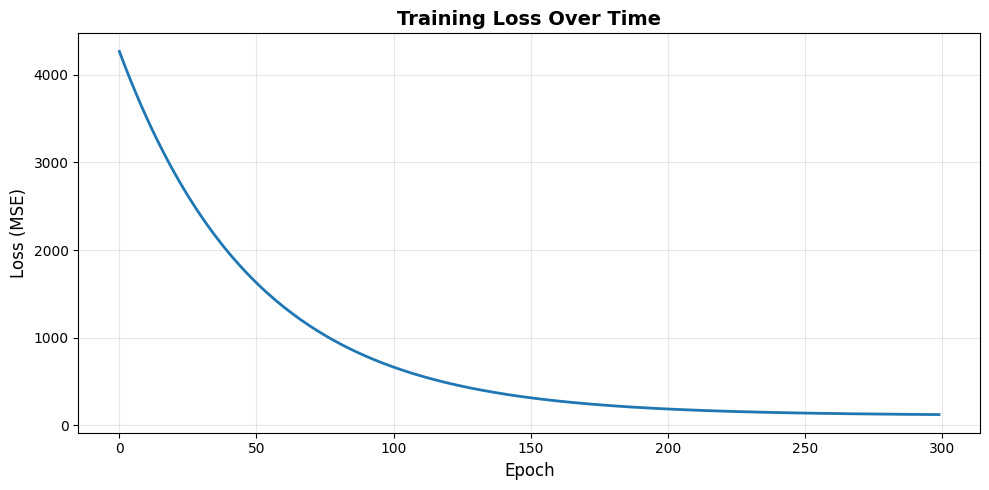


✓ Final RMSE: 11.09 points


In [6]:
# ============================================================================
# VISUALIZE TRAINING PROGRESS
# ============================================================================

plt.figure(figsize=(10, 5))

# Plot loss over epochs
plt.plot(loss_history, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training Loss Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Final RMSE: {np.sqrt(loss_history[-1]):.2f} points")

# ============================================================================